In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Dropout, GRU, LSTM, Bidirectional, SpatialDropout1D, TextVectorization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

# def remove_english_stopwords(text):
#    stop_words = set(stopwords.words('english'))
#    word_tokens = word_tokenize(text)
#    filtered_text = [word for word in word_tokens if not word in stop_words]
#    return ' '.join(filtered_text)

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def preprocess(text):
    text = remove_nonaplhanumeric(text) 
    text = remove_unnecessary_char(text) 
#     text = remove_english_stopwords(text) 
    return text

In [4]:
train_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv',index_col='id')
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
# train_data['comment_text'] = train_data['comment_text'].apply(preprocess)
# train_data.head()

In [6]:
train_data['comment_length'] = train_data['comment_text'].apply(lambda row: len(row))
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
id,,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

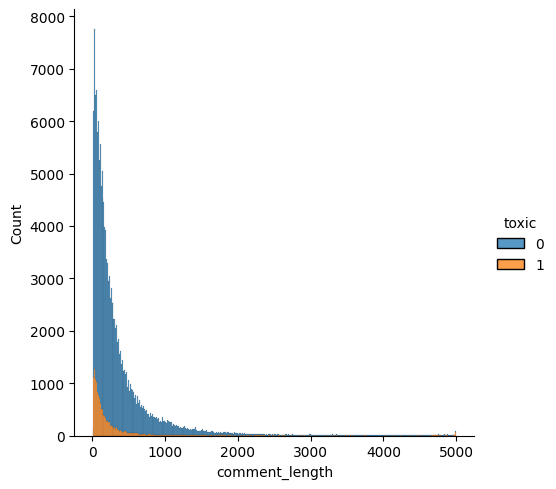

In [7]:
import seaborn as sns
sns.displot(
    data=train_data, 
    x="comment_length", 
    hue='toxic',
    multiple="stack",
)

In [8]:
toxic_data = train_data[train_data['toxic'] == 1]
toxic_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
id,,,,,,,,
0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,44
0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,319
0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,57
001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,648
00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,40


In [9]:
print(
    'max', toxic_data['comment_length'].max(),
    'min', toxic_data['comment_length'].min(),
    'mean', toxic_data['comment_length'].mean(),
    'median', toxic_data['comment_length'].median(),
    '75%', toxic_data['comment_length'].quantile(0.75),
)

max 5000 min 8 mean 295.24604420034 median 123.0 75% 271.0


In [10]:
max_comment_len = 300

In [11]:
test_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv',index_col='id')
test_data.head()

,comment_text
id,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7,== From RfC == \n\n The title is fine as it is...
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
00017563c3f7919a,":If you have a look back at the source, the in..."
00017695ad8997eb,I don't anonymously edit articles at all.


In [12]:
test_labels_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv',index_col='id')
test_labels_data.head()


,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,-1,-1,-1,-1,-1,-1
0000247867823ef7,-1,-1,-1,-1,-1,-1
00013b17ad220c46,-1,-1,-1,-1,-1,-1
00017563c3f7919a,-1,-1,-1,-1,-1,-1
00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [13]:
test_data = test_data.join(test_labels_data)
test_data = test_data[test_data['toxic'] != -1]
test_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


In [14]:
num_words = 10000
encoder = TextVectorization(max_tokens=num_words)
encoder.adapt(train_data['comment_text'].values)

from tensorflow.keras.layers import BatchNormalization

model_gru = Sequential([
    encoder,
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True,
        input_length=max_comment_len,
    ),
    SpatialDropout1D(0.5),
    GRU(20, return_sequences=True),
    BatchNormalization(),
    GRU(20),
    Dense(6, activation='sigmoid'),
])


In [15]:
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [16]:
model_gru_save_path = '/kaggle/working/toxic_model_gru'
checkpoint_callback_gru = ModelCheckpoint(
    model_gru_save_path, 
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    save_format='tf',
)

In [17]:
!rm -r /kaggle/working/toxic_model_gru

rm: cannot remove '/kaggle/working/toxic_model_gru': No such file or directory


In [18]:
x_train1 = train_data['comment_text'].values
y_train1 = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [19]:
from sklearn.model_selection import train_test_split 
x_train,x_val,y_train,y_val=train_test_split(x_train1,y_train1,train_size=0.8,shuffle=True,random_state=42)

In [20]:
x_train[:2]

array(['Grandma Terri Should Burn in Trash \nGrandma Terri is trash. I hate Grandma Terri. F%%K her to HELL! 71.74.76.40',
       ', 9 May 2009 (UTC)\nIt would be easiest if you were to admit to being a member of the involved Portuguese Lodge, and then there would be no requirement to acknowledge whether you had a previous account (Carlos Botelho did not have a good record) or not and I would then remove the sockpuppet template as irrelevant. WP:COI permits people to edit those articles, such as MSJapan does, but just means you have to be more careful in ensuring that references back your edits and that NPOV is upheld.   20:29'],
      dtype=object)

In [21]:
y_train[:2]

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [22]:
history_gru = model_gru.fit(
    x_train, 
    y_train, 
    epochs=5, # 15
    batch_size=512,
    validation_data=(x_val,y_val),
    callbacks=[checkpoint_callback_gru],
)

Epoch 1/5
250/250 [==============================] - ETA: 0s - loss: 0.1943 - accuracy: 0.2653 - auc: 0.8123
Epoch 1: val_accuracy improved from -inf to 0.97177, saving model to /kaggle/working/toxic_model_gru
250/250 [==============================] - 95s 333ms/step - loss: 0.1943 - accuracy: 0.2653 - auc: 0.8123 - val_loss: 0.0836 - val_accuracy: 0.9718 - val_auc: 0.9454
Epoch 2/5
250/250 [==============================] - ETA: 0s - loss: 0.0644 - accuracy: 0.9832 - auc: 0.9672
Epoch 2: val_accuracy improved from 0.97177 to 0.98881, saving model to /kaggle/working/toxic_model_gru
250/250 [==============================] - 65s 262ms/step - loss: 0.0644 - accuracy: 0.9832 - auc: 0.9672 - val_loss: 0.0580 - val_accuracy: 0.9888 - val_auc: 0.9759
Epoch 3/5
250/250 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9898 - auc: 0.9779
Epoch 3: val_accuracy improved from 0.98881 to 0.99041, saving model to /kaggle/working/toxic_model_gru
250/250 [=======================

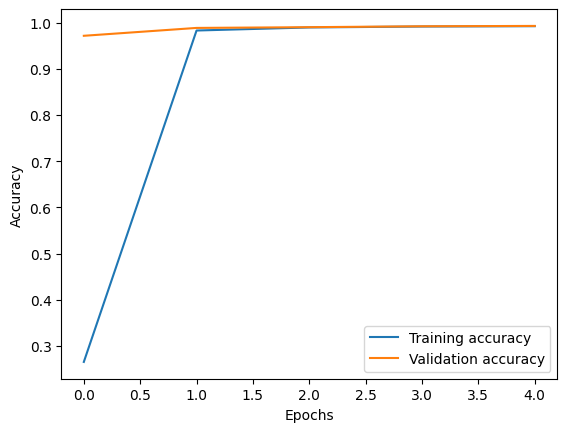

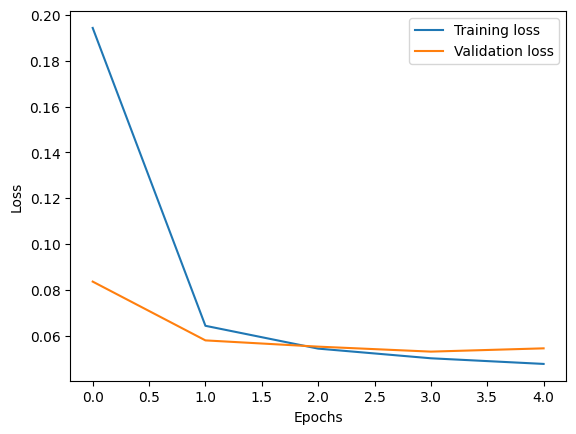

In [23]:
plt.plot(history_gru.history['accuracy'], 
         label='Training accuracy')
plt.plot(history_gru.history['val_accuracy'], 
         label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(history_gru.history['loss'], 
         label='Training loss')
plt.plot(history_gru.history['val_loss'], 
         label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
x_test = test_data['comment_text'].values
y_test = test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [25]:
model_gru.evaluate(x_test, y_test, verbose=1)

2000/2000 [==============================] - 31s 16ms/step - loss: 0.0948 - accuracy: 0.9960 - auc: 0.9673


[0.09483090043067932, 0.9960299134254456, 0.9673377275466919]

In [26]:
saved_model = load_model(model_gru_save_path)

In [27]:
test_data[test_data['toxic']==1][:5]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
00091c35fa9d0465,"== Arabs are committing genocide in Iraq, but ...",1,0,0,0,0,0
0013fed3aeae76b7,DJ Robinson is gay as hell! he sucks his dick ...,1,0,1,0,1,1
0017d4d47894af05,":Fuck off, you anti-semitic cunt. |",1,0,1,0,1,0
001d739c97bc2ae4,How dare you vandalize that page about the HMS...,1,0,0,0,0,0
001eff4007dbb65b,"::No, he is an arrogant, self serving, immatur...",1,0,1,0,1,0


In [28]:
test_data[test_data['toxic']==1][:5]['comment_text'].values

array(['== Arabs are committing genocide in Iraq, but no protests in Europe. == \n\n May Europe also burn in hell.',
       'DJ Robinson is gay as hell! he sucks his dick so much!!!!!',
       ':Fuck off, you anti-semitic cunt.  |',
       "How dare you vandalize that page about the HMS Beagle! Don't vandalize again, demon!",
       '::No, he is an arrogant, self serving, immature idiot. Get it right.'],
      dtype=object)

In [29]:
test_labels = saved_model.predict(test_data[test_data['toxic']==1][:5]['comment_text'].values)
for labels in test_labels:
    print([ round(lbl, 2) for lbl in labels])

1/1 [==============================] - 2s 2s/step
[0.51, 0.01, 0.12, 0.0, 0.14, 0.01]
[0.95, 0.12, 0.83, 0.03, 0.72, 0.1]
[0.98, 0.44, 0.95, 0.11, 0.93, 0.25]
[0.41, 0.01, 0.04, 0.01, 0.07, 0.01]
[0.97, 0.15, 0.81, 0.05, 0.78, 0.13]


In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predicts_val = saved_model.predict(x_val, verbose=1)

for threshold in thresholds:
  y_pred_val = (predicts_val > threshold)
  clr = classification_report(y_val, y_pred_val)
  accuracy = accuracy_score(y_val, y_pred_val)
  f1 = f1_score(y_val, y_pred_val, average='weighted')
  precision = precision_score(y_val, y_pred_val, average='weighted')
  recall = recall_score(y_val, y_pred_val, average='weighted')
  print(f"Threshold: {threshold}\nClassification Report:\n----------------------\n{clr}\nF1 Score: {f1}\nPrecision: {precision}\nRecall: {recall}\n\nAccuracy: {accuracy}\n")

998/998 [==============================] - 13s 13ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.1
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.48      0.93      0.63      3056
           1       0.22      0.92      0.36       321
           2       0.51      0.95      0.66      1715
           3       0.05      0.24      0.09        74
           4       0.43      0.94      0.59      1614
           5       0.13      0.57      0.21       294

   micro avg       0.42      0.91      0.57      7074
   macro avg       0.31      0.76      0.43      7074
weighted avg       0.45      0.91      0.60      7074
 samples avg       0.06      0.09      0.07      7074

F1 Score: 0.5963506512104878
Precision: 0.44741510869558687
Recall: 0.9112242013005372

Accuracy: 0.8243772520758265

Threshold: 0.2
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.57      0.89      0.69      3056
           1       0.30      0.79      0.43       321


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.4
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.69      0.83      0.76      3056
           1       0.48      0.39      0.43       321
           2       0.72      0.87      0.79      1715
           3       0.00      0.00      0.00        74
           4       0.65      0.79      0.71      1614
           5       0.25      0.01      0.02       294

   micro avg       0.68      0.77      0.72      7074
   macro avg       0.46      0.48      0.45      7074
weighted avg       0.65      0.77      0.70      7074
 samples avg       0.07      0.07      0.07      7074

F1 Score: 0.7006273054014003
Precision: 0.6536701299768231
Recall: 0.7694373763076053

Accuracy: 0.9012376625411249

Threshold: 0.5
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      3056
           1       0.49      0.09      0.15       321
 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:13

Threshold: 0.7
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.86      0.71      0.78      3056
           1       0.00      0.00      0.00       321
           2       0.84      0.74      0.79      1715
           3       0.00      0.00      0.00        74
           4       0.75      0.59      0.66      1614
           5       0.00      0.00      0.00       294

   micro avg       0.83      0.62      0.71      7074
   macro avg       0.41      0.34      0.37      7074
weighted avg       0.75      0.62      0.68      7074
 samples avg       0.06      0.06      0.06      7074

F1 Score: 0.6781755226354276
Precision: 0.7463988001128748
Recall: 0.6218546791065875

Accuracy: 0.9169356102146327

Threshold: 0.8
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.90      0.65      0.75      3056
           1       0.00      0.00      0.00       321
 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predicts = saved_model.predict(x_test, verbose=1)

for threshold in thresholds:
  y_pred = (predicts > threshold)
  f1 = f1_score(y_test, y_pred, average='weighted')
  accuracy = accuracy_score(y_test, y_pred)
  clr = classification_report(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  print(f"Threshold: {threshold}\nClassification Report:\n----------------------\n{clr}\nF1 Score: {f1}\nPrecision: {precision}\nRecall: {recall}\n\nAccuracy: {accuracy}\n")

2000/2000 [==============================] - 28s 14ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.1
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.32      0.96      0.48      6090
           1       0.10      0.93      0.18       367
           2       0.31      0.94      0.47      3691
           3       0.08      0.27      0.12       211
           4       0.26      0.94      0.41      3427
           5       0.13      0.61      0.21       712

   micro avg       0.27      0.92      0.42     14498
   macro avg       0.20      0.78      0.31     14498
weighted avg       0.29      0.92      0.44     14498
 samples avg       0.06      0.09      0.07     14498

F1 Score: 0.4366162657552304
Precision: 0.2876705345650551
Recall: 0.9215064146778866

Accuracy: 0.7268748632342368

Threshold: 0.2
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.36      0.94      0.52      6090
           1       0.16      0.81      0.26       367
 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.3
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.40      0.92      0.56      6090
           1       0.21      0.65      0.32       367
           2       0.43      0.88      0.58      3691
           3       0.03      0.00      0.01       211
           4       0.38      0.84      0.53      3427
           5       0.18      0.04      0.06       712

   micro avg       0.39      0.83      0.53     14498
   macro avg       0.27      0.56      0.34     14498
weighted avg       0.38      0.83      0.52     14498
 samples avg       0.07      0.08      0.07     14498

F1 Score: 0.5164883473196769
Precision: 0.3821838581454785
Recall: 0.8281142226514002

Accuracy: 0.8027759542342681

Threshold: 0.4
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.43      0.90      0.58      6090
           1       0.27      0.43      0.33       367
 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.5
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.47      0.87      0.61      6090
           1       0.41      0.12      0.19       367
           2       0.52      0.81      0.63      3691
           3       0.00      0.00      0.00       211
           4       0.48      0.71      0.58      3427
           5       0.08      0.00      0.00       712

   micro avg       0.49      0.74      0.59     14498
   macro avg       0.33      0.42      0.34     14498
weighted avg       0.46      0.74      0.56     14498
 samples avg       0.07      0.07      0.07     14498

F1 Score: 0.5596955232768982
Precision: 0.4593365124207326
Recall: 0.7445164850324183

Accuracy: 0.8469473881646816

Threshold: 0.6
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.51      0.84      0.64      6090
           1       0.20      0.00      0.01       367
 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

Threshold: 0.7
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.56      0.79      0.65      6090
           1       0.00      0.00      0.00       367
           2       0.63      0.70      0.66      3691
           3       0.00      0.00      0.00       211
           4       0.61      0.55      0.58      3427
           5       0.00      0.00      0.00       712

   micro avg       0.59      0.64      0.61     14498
   macro avg       0.30      0.34      0.32     14498
weighted avg       0.54      0.64      0.58     14498
 samples avg       0.07      0.06      0.06     14498

F1 Score: 0.5813778867766913
Precision: 0.5392732234020049
Recall: 0.6419506138777763

Accuracy: 0.8766450967520085

Threshold: 0.8
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.61      0.71      0.66      6090
           1       0.00      0.00      0.00       367
 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

In [32]:
!zip -r /kaggle/working/toxic_model_gru.zip /kaggle/working/toxic_model_gru

  adding: kaggle/working/toxic_model_gru/ (stored 0%)
  adding: kaggle/working/toxic_model_gru/fingerprint.pb (stored 0%)
  adding: kaggle/working/toxic_model_gru/saved_model.pb (deflated 89%)
  adding: kaggle/working/toxic_model_gru/assets/ (stored 0%)
  adding: kaggle/working/toxic_model_gru/keras_metadata.pb (deflated 89%)
  adding: kaggle/working/toxic_model_gru/variables/ (stored 0%)
  adding: kaggle/working/toxic_model_gru/variables/variables.index (deflated 63%)
  adding: kaggle/working/toxic_model_gru/variables/variables.data-00000-of-00001 (deflated 7%)
